In [1]:
import tensorflow as tf
print(tf.__version__)
# Additional imports
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2.10.0


# Make the original data
we will write down a notebook for an AR model using a synthetic dataset

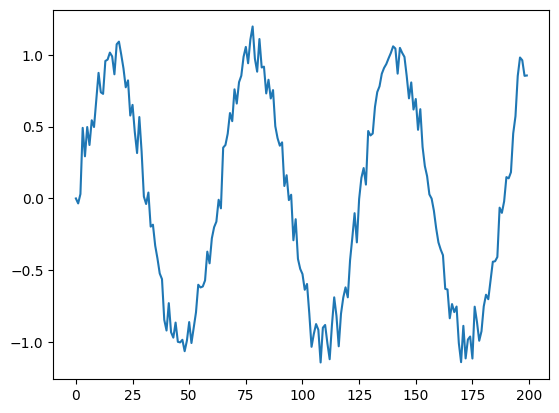

In [2]:
series = np.sin(0.1*np.arange(200)) +  np.random.randn(200)*0.1

# Plot it
plt.plot(series)


## Build the dataset
lets see if we cn use T past values to predict the next value

In [ ]:

T = 10
X = []
Y = []

for t in range(len(series) -T):
    X.append(series[t:t+T])
    Y.append(series[t+T])

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)
N = X.shape[0]
# rsults should be X.shape (190, 10) Y.shape (190,)

In [ ]:
print(X[0])
print(Y[0])

In [ ]:
plt.plot(series[:100])

### Try the autoregressive linear model
    1 - create a model with one dense layer
    2 - complile model using mse loss

In [ ]:
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)


model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.1),
    metrics=["mae"]
)




train the RNN

In [ ]:

r = model.fit(
    X[:-N//2],Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

# "Wrong" 
### forecast using true targets

In [ ]:
model.predict(X[0].reshape(1,-1))

In [ ]:
model.predict(X[-N//2].reshape(1,-1))[0,0]

In [ ]:

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1,-1))[0,0]# predict output  -- 1x1 array => scalar
    i += 1
    # update the predictions list
    validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Forecast future values (use only self-predictions for making predictions)

In [ ]:
a = np.array([1, 2, 3])
print(np.roll(a,-1))

In [ ]:

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
    # predict one step
    p = model.predict(last_x.reshape(1,-1))[0,0]

    # update the predictions list
    validation_predictions.append(p)

    # make the new input (use np.roll)
    last_x = np.roll(last_x,-1)
    last_x[-1] = p
    
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Now we will use RNN

### Build the dataset
lets see if we cn use T past values to predict the next value

In [ ]:

T = 10
D = 1
X = []
Y = []
for t in range(len(series) -T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
X = np.array(X)
X = X[:,:,np.newaxis]
Y = np.array(Y)

#  Create Model

In [ ]:
input1 = tf.keras.layers.Input(shape=(T, D))
hidden = tf.keras.layers.SimpleRNN(10, activation=None)(input1)
output = tf.keras.layers.Dense(1)(hidden)

model = Model(input1, output)

In [ ]:
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.05),
    metrics=['mae']
)

In [ ]:
r = model.fit(
    X[:-N//2],Y[:-N//2],
    epochs=200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

In [ ]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

## Try the Simple RNN model

### Forecast future values (use only self-predictions for making predictions)


In [ ]:

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1,-1,1))[0,0] #1x1 array => scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

- its not perfect like AR model. 
- RNN is more flexible 
- we have some shifting

- if we set in SimpleRNN activation=None our forecast is perfect like with AR. without activation method the model reduces to a linear model

- we add noise keeping activation=None

- 1 step forecast but multistep one is bad.same for tanh activation

- with relu activation is even worse in multistep forecast. loks like copying previous value

# Things we should know and memorize

- N = number of samples
- T = sequence length
- D = number of input features
- M = number of hidden units (neurons)
- K = number of output units (neurons)

In [ ]:
# Make some data
N = 1
T = 10
D = 3
K = 2
X = np.random.randn(N, T, D)
# Make an RNN

M = 5 # number of hidden units

i = Input(shape=(T,D))
x = SimpleRNN(M)(i)
x = Dense(K)(x)

model = Model(i,x)
# Get the output
Yhat = model.predict(X)
print(Yhat)
print('Yhat.shape', Yhat.shape)

In [ ]:
w_xh = model.layers[1].get_weights()[0]
w_hh = model.layers[1].get_weights()[1]
w_o = model.layers[2].get_weights()[0]

print("w_xh size = " + str(w_xh.shape))
print("w_hh size = " + str(w_hh.shape))
print("w_o size = " + str(w_o.shape))

In [ ]:
# see if we can replicate this output
# get the weights first
model.summary()
# see what's returned
model.layers[1].get_weights()
# Check their shapes
# Should make sense
# First output is input > hidden
# Second output is hidden > hidden
# Third output is bias term (vector of length M)
a,b,c = model.layers[1].get_weights()
print(a.shape,b.shape,c.shape)

# More complicated data

In [3]:
# Additional imports
from tensorflow.keras.layers import Input,Dense,Flatten,SimpleRNN,GRU,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



X.shape (390, 10) Y.shape (390,)


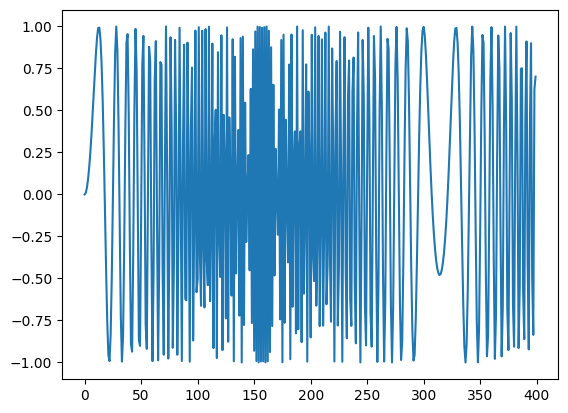

In [4]:
# make the synthtic original data
series = np.sin((0.1*np.arange(400))**2) #x(t)=sin(ωt^2)
# plot it
plt.plot(series)

### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)



# Autoregressive linear model


In [ ]:
# try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)

model.compile(
    loss="mse",
    optimizer = Adam(learning_rate=0.01),
)

# train the model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

In [ ]:
# Forecast future values (use only self-predictions for making predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1,-1))[0,0] #1x1 array => scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Now Try an RNN/LSTM model

In [8]:
### Now Try an RNN/LSTM model
X = X.reshape(-1,T,1) # make it NxTxD

# make the RNN
i = Input(shape=(T,D))
x = SimpleRNN(10)(i)
x = Dense(1)(x)

model = Model(i,x)
model.compile(
    loss="mse",
    optimizer= Adam(learning_rate=0.05),
)

# train the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)




Epoch 1/200


InternalError: Graph execution error:

Detected at node 'model_3/simple_rnn/while/simple_rnn_cell/MatMul_1' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\n2zia\AppData\Local\Temp\ipykernel_29640\296200742.py", line 16, in <module>
      r = model.fit(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\layers\rnn\simple_rnn.py", line 410, in call
      return super().call(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\layers\rnn\base_rnn.py", line 719, in call
      last_output, outputs, states = backend.rnn(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\backend.py", line 5139, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\backend.py", line 5118, in _step
      output, new_states = step_function(
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\layers\rnn\base_rnn.py", line 714, in step
      output, new_states = cell_call_fn(inputs, states, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\layers\rnn\simple_rnn.py", line 209, in call
      output = h + backend.dot(prev_output, self.recurrent_kernel)
    File "C:\ProgramData\Anaconda3\envs\tf2_gpu\lib\site-packages\keras\backend.py", line 2455, in dot
      out = tf.matmul(x, y)
Node: 'model_3/simple_rnn/while/simple_rnn_cell/MatMul_1'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node model_3/simple_rnn/while/simple_rnn_cell/MatMul_1}}]] [Op:__inference_train_function_10166]

In [ ]:
# Forecast future values (use only self-predictions for making predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1,-1))[0,0] #1x1 array => scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [7]:
### Now Try an RNN/LSTM model
X = X.reshape(-1,T,1) # make it NxTxD

# make the RNN
i = Input(shape=(T,D))
x = tf.keras.layers.GRU(10)(i)
x = Dense(1)(x)


model = Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.05),
)

# train the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

Epoch 1/200


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_2/gru_1/PartitionedCall]] [Op:__inference_train_function_8898]

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('many-to-one RNN')
plt.legend()



In [ ]:
# multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) <len(Y[-N//2:]):
    # reshape the input to NxTxD
    f = model.predict(input_.reshape(1,T,1))[0,0]
    forecast.append(f)

    #make a new input with the latest forecast
    input_ = np.roll(input_,-1)
    input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title('RNN forecast')
plt.legend()
np.mean(np.abs(forecast-Y[-N//2:]))

In [ ]:
from tensorflow.keras.layers import GRU
### Now Try an RNN/LSTM model
X = X.reshape(-1,T,1) # make it NxTxD

# make the RNN
i = Input(shape=(T,D))
x = GRU(10)(i)
x = Dense(1)(x)


model = Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.05),
)

# train the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('many-to-one RNN')
plt.legend()

In [ ]:
# multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) <len(Y[-N//2:]):
    # reshape the input to NxTxD
    f = model.predict(input_.reshape(1,T,1))[0,0]
    forecast.append(f)

    #make a new input with the latest forecast
    input_ = np.roll(input_,-1)
    input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title('RNN forecast')
plt.legend()



In [ ]:
np.mean(np.abs(forecast-Y[-N//2:]))